In [1]:
#Imports
import xarray as xr
import sys
sys.path.append('/home/563/rl5183/Functions')
import model_functions as func
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
from scipy.stats.stats import pearsonr
import iris
import iris.analysis.stats as istats
from importlib import reload
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
func=reload(func)

In [3]:
#Historical model runs
hist_temp = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/ts/gr1.5/')
hist_precip = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/')

GISS-E2-2-G path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
45 model paths found and stored in models dictionary
MPI-ESM-1-2-HAM /g/data/lp01/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/ts/gr1.5/v20190627/*.nc
NESM3 /g/data/lp01/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/ts/gr1.5/v20190630/*.nc
MCM-UA-1-0 /g/data/lp01/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/ts/gr1.5/v20190731/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/ts/gr1.5/v20190919/*.nc
MPI-ESM1-2-HR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historic

In [4]:
#Future model runs
future_temp = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/ts/gr1.5/')
future_precip = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/pr/gr1.5/')

MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
29 model paths found and stored in models dictionary
NESM3 /g/data/lp01/CMIP6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190728/*.nc
ACCESS-CM2 /g/data/lp01/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190924/*.nc
MPI-ESM1-2-LR /g/data/lp01/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190710/*.nc
IPSL-CM6A-LR /g/data/lp01/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190119/*.nc
FGOALS-f3-L /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20191013/*.nc
FGOALS-g3 /g/data/lp01/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp585/r1i1p1f1/Amon/ts/gr1.5/v20190818/*.nc
BCC-CSM2-MR /g/data/lp01/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Amon/ts/gr1.5/v201903

In [5]:
#Find common models between all four datasets
hist_temp = hist_temp.where(hist_temp.model.isin(hist_precip.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_temp.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_precip.model), drop = True)
hist_precip = hist_precip.where(hist_precip.model.isin(hist_temp.model), drop = True)
future_temp = future_temp.where(future_temp.model.isin(hist_temp.model), drop = True)
future_precip = future_precip.where(future_precip.model.isin(hist_temp.model), drop = True)

In [6]:
#Detrend future temp data
future_ts_data = future_temp.ts

future_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, future_ts_data)

future_ts = xr.DataArray(future_ts_dt, coords=future_ts_data.coords, attrs=future_ts_data.attrs)

In [7]:
#Detrend historical temp data
hist_ts_data = hist_temp.ts

hist_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, hist_ts_data)

hist_ts = xr.DataArray(hist_ts_dt, coords=hist_ts_data.coords, attrs=hist_ts_data.attrs)

In [8]:
#precip
hist_pr = hist_precip.pr
future_pr = future_precip.pr

In [9]:
#discard models rejected by model evaluation
future_ts = future_ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_ts = hist_ts.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
future_pr = future_pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_pr = hist_pr.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])

In [10]:
#sort models alphabetically
future_ts = future_ts.sortby('model')
hist_ts = hist_ts.sortby('model')
future_pr = future_pr.sortby('model')
hist_pr = hist_pr.sortby('model')

In [11]:
#30 year climatology for comparison 
future_clim_ts = future_ts.sel(time=slice('2070-01', '2099-12'))
hist_clim_ts = hist_ts.sel(time=slice('1970-01', '1999-12'))
hist_clim_pr = hist_pr.sel(time=slice('1970-01','1999-12'))
hist_clim_pr = hist_clim_pr*86400
future_clim_pr = future_pr.sel(time=slice('2070-01','2099-12'))
future_clim_pr = future_clim_pr*86400

### Precip data and Nino3.4 index

In [12]:
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

In [13]:
#Precip aus
future_pr_aus = future_clim_pr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10))
hist_pr_aus = hist_clim_pr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10))

#Precip EA
future_pr_ea = future_clim_pr.sel(lon = slice(140, 156)).sel(lat=slice(-44, -10))
hist_pr_ea = hist_clim_pr.sel(lon = slice(140, 156)).sel(lat=slice(-44, -10))

#Nino34 index
nino34_list = []

for m in future_clim_ts.model:
    nino34_list.append(func.nino34_clim(future_clim_ts.sel(model=m)))
    
nino34 = xr.concat(nino34_list, dim='model')

nino34_list_hist = []

for m in hist_clim_ts.model:
    nino34_list_hist.append(func.nino34_clim(hist_clim_ts.sel(model=m)))
    
nino34_hist = xr.concat(nino34_list_hist, dim='model')

### Spatial Corr with statistical significance DJF

In [14]:
#Pearsons r and pvalues future DJF
pearson_list_djf = []
pvalues_list_djf = []

for m in future_pr_ea.model:
    r, p = func.spatial_corr_clim(future_pr_ea.sel(model=m), nino34.sel(model=m), 'DJF', 2100)
    pearson_list_djf.append(r)
    pvalues_list_djf.append(p)

pearson_djf = xr.DataArray(pearson_list_djf, dims=['model', 'lat', 'lon'])
pearson_djf.coords['model'] = future_pr_ea.model.values
pearson_djf.coords['lat'] = future_pr_ea.lat.values
pearson_djf.coords['lon'] = future_pr_ea.lon.values

pearson_djf = pearson_djf.where(landmask.data==1)

pvalues_djf = xr.DataArray(pvalues_list_djf, dims=['model', 'lat', 'lon'])
pvalues_djf.coords['model'] = future_pr_ea.model.values
pvalues_djf.coords['lat'] = future_pr_ea.lat.values
pvalues_djf.coords['lon'] = future_pr_ea.lon.values

pvalues_djf = pvalues_djf.where(landmask.data==1)
pvalues_djf = pvalues_djf.where(pvalues_djf.data<0.05)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [15]:
#Pearsons r and pvalues hist DJF
pearson_list_djf_hist = []
pvalues_list_djf_hist = []

for m in hist_pr_ea.model:
    r, p = func.spatial_corr_clim(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF', 2000)
    pearson_list_djf_hist.append(r)
    pvalues_list_djf_hist.append(p)
    
pearson_djf_hist = xr.DataArray(pearson_list_djf_hist, dims=['model', 'lat', 'lon'])
pearson_djf_hist.coords['model'] = hist_pr_ea.model.values
pearson_djf_hist.coords['lat'] = hist_pr_ea.lat.values
pearson_djf_hist.coords['lon'] = hist_pr_ea.lon.values

pearson_djf_hist = pearson_djf_hist.where(landmask.data==1)

pvalues_djf_hist = xr.DataArray(pvalues_list_djf_hist, dims=['model', 'lat', 'lon'])
pvalues_djf_hist.coords['model'] = hist_pr_ea.model.values
pvalues_djf_hist.coords['lat'] = hist_pr_ea.lat.values
pvalues_djf_hist.coords['lon'] = hist_pr_ea.lon.values

pvalues_djf_hist = pvalues_djf_hist.where(landmask.data==1)
pvalues_djf_hist = pvalues_djf_hist.where(pvalues_djf_hist.data<0.05)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Text(0, 0.5, 'Pearson correlation coefficient')

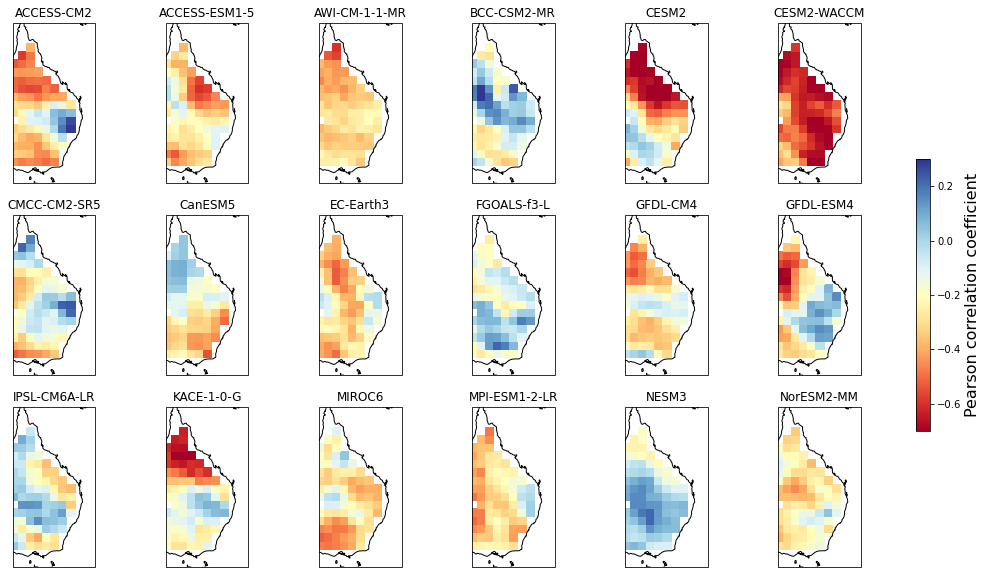

In [16]:
#spatial corr plots future DJF
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_djf.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_djf.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_djf_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'P-value')

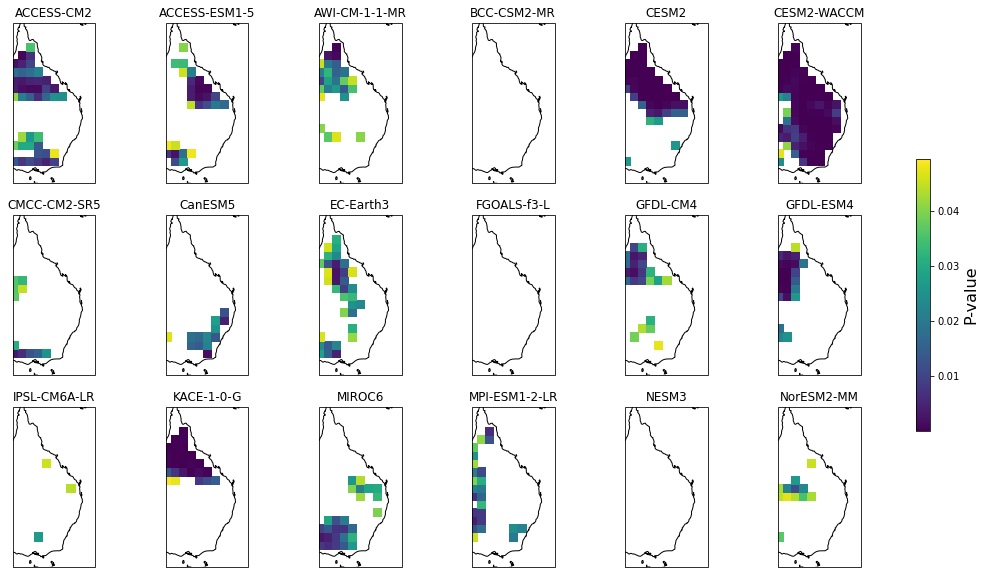

In [17]:
#Pvalues future djf
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = pvalues_djf.min()
vmax = pvalues_djf.max()

for i, m in enumerate(pvalues_djf.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pvalues_djf.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('P-value', fontsize=16)

#plt.savefig('pvalues_djf_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'Pearson correlation coefficient')

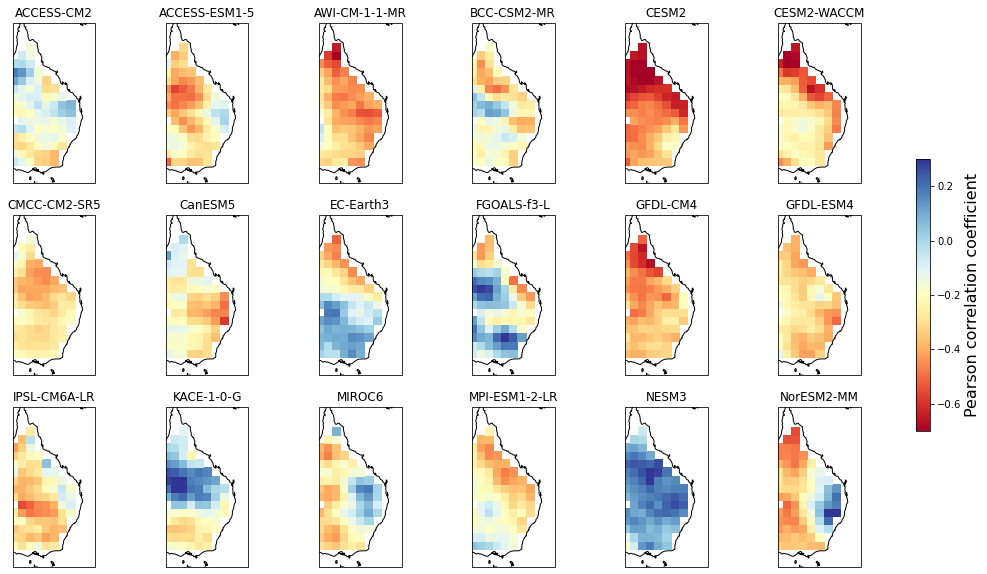

In [18]:
#spatial corr plots hist djf 
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_djf_hist.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_djf_hist.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_djf_hist.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'P-value')

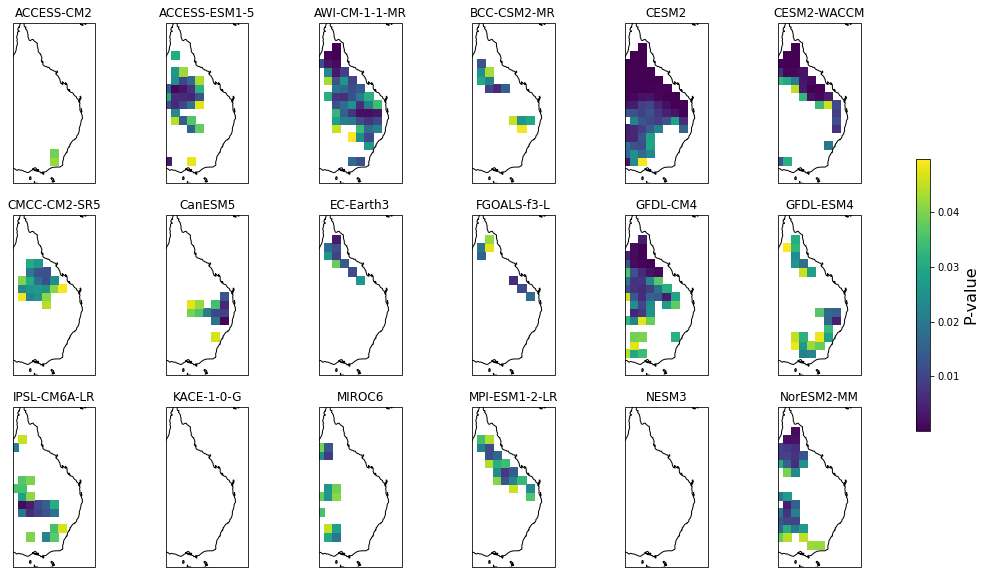

In [19]:
#Pvalues future djf
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = pvalues_djf_hist.min()
vmax = pvalues_djf_hist.max()

for i, m in enumerate(pvalues_djf_hist.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pvalues_djf_hist.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('P-value', fontsize=16)

#plt.savefig('pvalues_djf_hist.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

In [20]:
#Percentage of land over eastern australia that has a significant teleconnection in hist and future period

percent_djf_hist_list = []

total_values = 242
total_area = 85

for m in pvalues_djf_hist.model:
    null_values = pvalues_djf_hist.sel(model=m).isnull().sum()
    significant_values = total_values - null_values
    percent = (significant_values/total_area)*100
    percent_djf_hist_list.append(percent)
    
percent_djf_hist = xr.DataArray(percent_djf_hist_list, dims='model')
percent_djf_hist.coords['model'] = pvalues_djf_hist.model.values

percent_djf_list = []

for m in pvalues_djf.model:
    null_values = pvalues_djf.sel(model=m).isnull().sum()
    significant_values = total_values - null_values
    percent = (significant_values/total_area)*100
    percent_djf_list.append(percent)
    
percent_djf = xr.DataArray(percent_djf_list, dims='model')
percent_djf.coords['model'] = pvalues_djf.model.values

In [21]:
np.set_printoptions(precision=0)

In [22]:
percent_djf

<xarray.DataArray (model: 18)>
array([52., 32., 31.,  0., 49., 92., 13., 15., 40.,  0., 27., 27.,  4.,
       31., 32., 29.,  0., 14.])
Coordinates:
  * model    (model) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NESM3' 'NorESM2-MM'

### Spatial corr with statistical significance SON

In [23]:
#Pearsons r and pvalues future SON
pearson_list_son = []
pvalues_list_son = []

for m in future_pr_ea.model:
    r, p = func.spatial_corr_clim(future_pr_ea.sel(model=m), nino34.sel(model=m), 'SON', 2100)
    pearson_list_son.append(r)
    pvalues_list_son.append(p)

pearson_son = xr.DataArray(pearson_list_son, dims=['model', 'lat', 'lon'])
pearson_son.coords['model'] = future_pr_ea.model.values
pearson_son.coords['lat'] = future_pr_ea.lat.values
pearson_son.coords['lon'] = future_pr_ea.lon.values

pearson_son = pearson_son.where(landmask.data==1)

pvalues_son = xr.DataArray(pvalues_list_son, dims=['model', 'lat', 'lon'])
pvalues_son.coords['model'] = future_pr_ea.model.values
pvalues_son.coords['lat'] = future_pr_ea.lat.values
pvalues_son.coords['lon'] = future_pr_ea.lon.values

pvalues_son = pvalues_son.where(landmask.data==1)
pvalues_son = pvalues_son.where(pvalues_son.data<0.05)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


In [24]:
#Pearsons r and pvalues hist DJF
pearson_list_son_hist = []
pvalues_list_son_hist = []

for m in hist_pr_ea.model:
    r, p = func.spatial_corr_clim(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'SON', 2000)
    pearson_list_son_hist.append(r)
    pvalues_list_son_hist.append(p)
    
pearson_son_hist = xr.DataArray(pearson_list_son_hist, dims=['model', 'lat', 'lon'])
pearson_son_hist.coords['model'] = hist_pr_ea.model.values
pearson_son_hist.coords['lat'] = hist_pr_ea.lat.values
pearson_son_hist.coords['lon'] = hist_pr_ea.lon.values

pearson_son_hist = pearson_son_hist.where(landmask.data==1)

pvalues_son_hist = xr.DataArray(pvalues_list_son_hist, dims=['model', 'lat', 'lon'])
pvalues_son_hist.coords['model'] = hist_pr_ea.model.values
pvalues_son_hist.coords['lat'] = hist_pr_ea.lat.values
pvalues_son_hist.coords['lon'] = hist_pr_ea.lon.values

pvalues_son_hist = pvalues_son_hist.where(landmask.data==1)
pvalues_son_hist = pvalues_son_hist.where(pvalues_son_hist.data<0.05)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Text(0, 0.5, 'Pearson correlation coefficient')

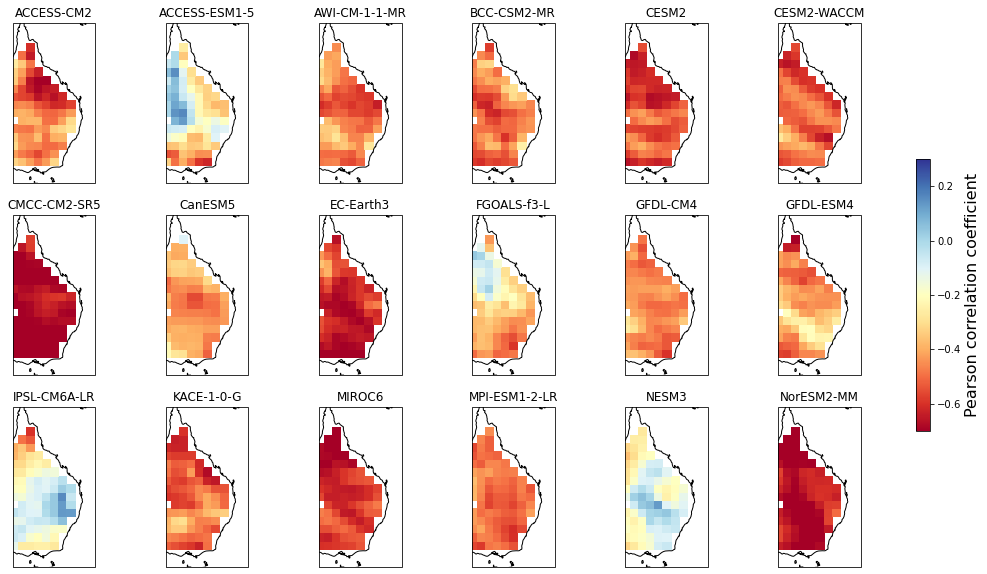

In [25]:
#spatial corr plots future SON
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_son.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_son.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_son_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'P-value')

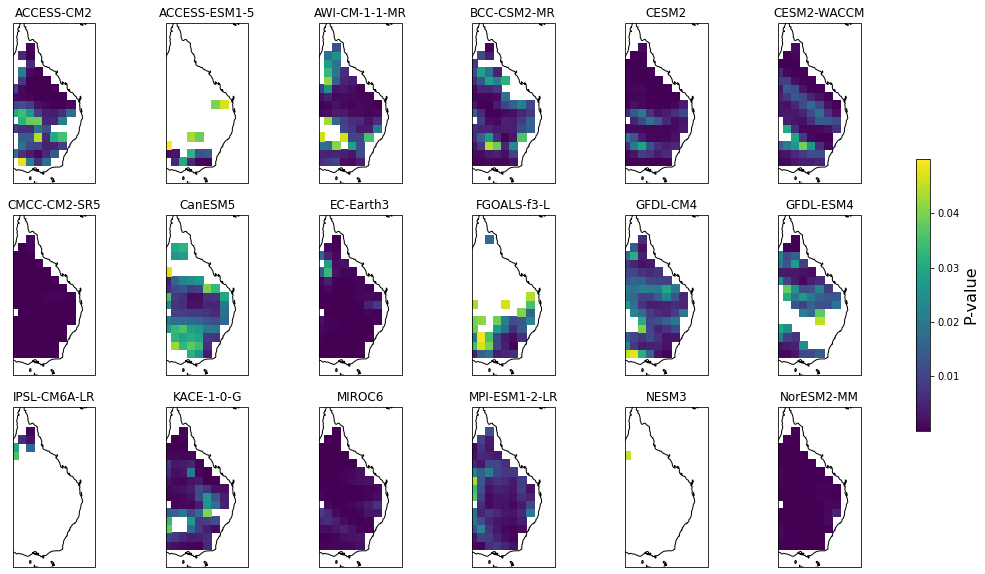

In [26]:
#Pvalues future SON
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = pvalues_son.min()
vmax = pvalues_son.max()

for i, m in enumerate(pvalues_son.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pvalues_son.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('P-value', fontsize=16)

#plt.savefig('pvalues_son_future.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'Pearson correlation coefficient')

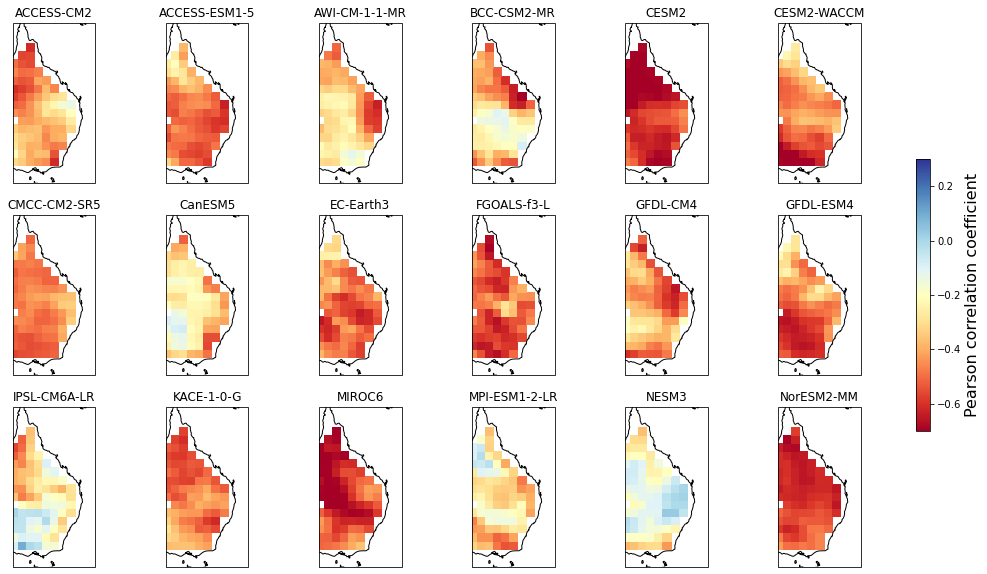

In [27]:
#spatial corr plots hist son
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = -0.7
vmax = 0.3

for i, m in enumerate(pearson_son_hist.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pearson_son_hist.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdYlBu')
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('Pearson correlation coefficient', fontsize=16)

#plt.savefig('spatial_corr_son_hist.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0, 0.5, 'P-value')

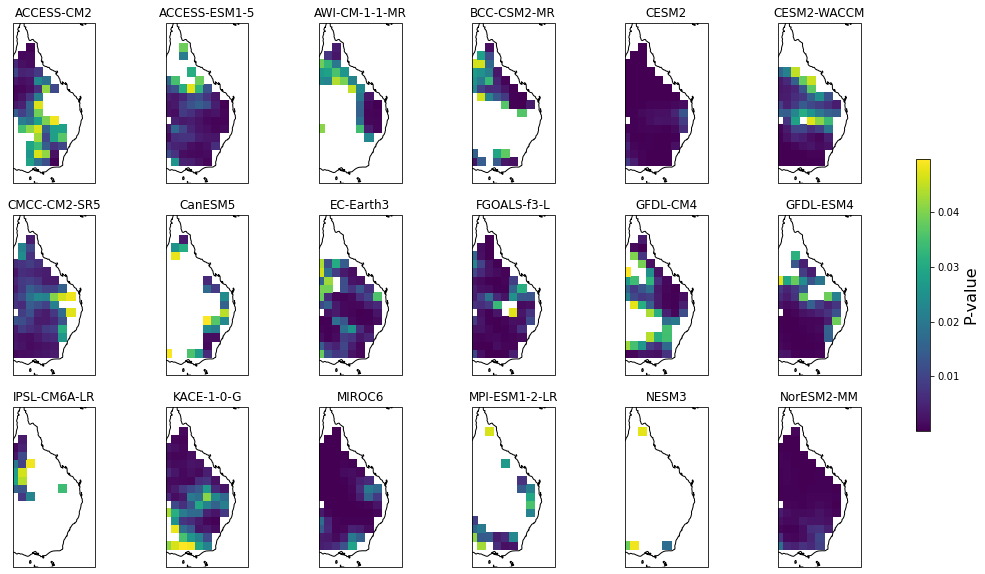

In [60]:
#Pvalues future son
fig = plt.figure(figsize=(20,10))
axs = []

columns = 6
rows = 3

vmin = pvalues_son_hist.min()
vmax = pvalues_son_hist.max()

for i, m in enumerate(pvalues_son_hist.model):
    # Add a subplot with a projection
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([140.75, 156, -40.75, -11.25])
    
    # Select this model's data and plot it
    # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
    d = pvalues_son_hist.sel(model=m)
    C = d.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)
cbar.ax.set_ylabel('P-value', fontsize=16)

#plt.savefig('pvalues_son_hist.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

In [29]:
#Percentage of land over eastern australia that has a significant teleconnection in hist and future period SON

percent_son_hist_list = []

total_values = 242
total_area = 85

for m in pvalues_son_hist.model:
    null_values = pvalues_son_hist.sel(model=m).isnull().sum()
    significant_values = total_values - null_values
    percent = (significant_values/total_area)*100
    percent_son_hist_list.append(percent)
    
percent_son_hist = xr.DataArray(percent_son_hist_list, dims='model')
percent_son_hist.coords['model'] = pvalues_son_hist.model.values

percent_son_list = []

for m in pvalues_son.model:
    null_values = pvalues_son.sel(model=m).isnull().sum()
    significant_values = total_values - null_values
    percent = (significant_values/total_area)*100
    percent_son_list.append(percent)
    
percent_son = xr.DataArray(percent_son_list, dims='model')
percent_son.coords['model'] = pvalues_son.model.values

In [30]:
percent_son

<xarray.DataArray (model: 18)>
array([ 86.,  18.,  88.,  92., 100.,  96., 100.,  81.,  99.,  45.,  94.,
        69.,   7.,  93., 100., 100.,   1., 100.])
Coordinates:
  * model    (model) <U13 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'NESM3' 'NorESM2-MM'

### Timeseries correlation

In [31]:
#precip timeseries
future_pr_ea_timeseries = future_pr_ea.mean(dim=['lat', 'lon'])
future_pr_ea_timeseries = future_pr_ea_timeseries - future_pr_ea_timeseries.mean(dim='time')
hist_pr_ea_timeseries = hist_pr_ea.mean(dim=['lat', 'lon'])
hist_pr_ea_timeseries = hist_pr_ea_timeseries - hist_pr_ea_timeseries.mean(dim='time')

In [32]:
#Nino indices 
nino3_list = []

for m in future_clim_ts.model:
    nino3_list.append(func.nino3_clim(future_clim_ts.sel(model=m)))
    
nino3 = xr.concat(nino3_list, dim='model')

nino3_list_hist = []

for m in hist_clim_ts.model:
    nino3_list_hist.append(func.nino3_clim(hist_clim_ts.sel(model=m)))
    
nino3_hist = xr.concat(nino3_list_hist, dim='model')

nino4_list = []

for m in future_clim_ts.model:
    nino4_list.append(func.nino4_clim(future_clim_ts.sel(model=m)))
    
nino4 = xr.concat(nino4_list, dim='model')

nino4_list_hist = []

for m in hist_clim_ts.model:
    nino4_list_hist.append(func.nino4_clim(hist_clim_ts.sel(model=m)))
    
nino4_hist = xr.concat(nino4_list_hist, dim='model')

In [33]:
future_nino3_r = []
future_nino3_p = []

for m in future_pr_ea_timeseries.model:
    r,p = pearsonr(future_pr_ea_timeseries.sel(model=m), nino3.sel(model=m))
    future_nino3_r.append(r)
    future_nino3_p.append(p)
    
future_nino34_r = []
future_nino34_p = []

for m in future_pr_ea_timeseries.model:
    r,p = pearsonr(future_pr_ea_timeseries.sel(model=m), nino34.sel(model=m))
    future_nino34_r.append(r)
    future_nino34_p.append(p)
    
future_nino4_r = []
future_nino4_p = []

for m in future_pr_ea_timeseries.model:
    r,p = pearsonr(future_pr_ea_timeseries.sel(model=m), nino4.sel(model=m))
    future_nino4_r.append(r)
    future_nino4_p.append(p)

In [34]:
hist_nino3_r = []
hist_nino3_p = []

for m in hist_pr_ea_timeseries.model:
    r,p = pearsonr(hist_pr_ea_timeseries.sel(model=m), nino3_hist.sel(model=m))
    hist_nino3_r.append(r)
    hist_nino3_p.append(p)
    
hist_nino34_r = []
hist_nino34_p = []

for m in hist_pr_ea_timeseries.model:
    r,p = pearsonr(hist_pr_ea_timeseries.sel(model=m), nino34_hist.sel(model=m))
    hist_nino34_r.append(r)
    hist_nino34_p.append(p)
    
hist_nino4_r = []
hist_nino4_p = []

for m in hist_pr_ea_timeseries.model:
    r,p = pearsonr(hist_pr_ea_timeseries.sel(model=m), nino4_hist.sel(model=m))
    hist_nino4_r.append(r)
    hist_nino4_p.append(p)

In [75]:
hist_nino4_r = np.array(hist_nino4_r)
hist_nino3_r = np.array(hist_nino3_r)
hist_nino34_r = np.array(hist_nino34_r)
future_nino4_r = np.array(future_nino4_r)
future_nino3_r = np.array(future_nino3_r)
future_nino34_r = np.array(future_nino34_r)

In [84]:
future_nino4_r

array([ 0.09, -0.02,  0.26,  0.05,  0.04,  0.03,  0.02,  0.18, -0.05,
       -0.11,  0.25,  0.16,  0.27,  0.1 , -0.24,  0.15,  0.31, -0.05])

### Area average rainfall east Aus

In [44]:
np.set_printoptions(precision=2)

In [36]:
#El Nino area average rainfall DJF future
nino_pr_djf_list = []

for m in future_pr_ea.model:
    nino_pr_djf_list.append(func.nino_pr_comp(future_pr_ea.sel(model=m), nino34.sel(model=m), 'DJF'))
    
nino_pr_djf = xr.concat(nino_pr_djf_list, dim='model')

nino_pr_djf = nino_pr_djf.where(landmask.data==1)
nino_pr_djf_av = nino_pr_djf.mean(dim=['lat', 'lon'])

#El Nino area average rainfall DJF historical
nino_pr_djf_list_hist = []

for m in hist_pr_ea.model:
    nino_pr_djf_list_hist.append(func.nino_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    
nino_pr_djf_hist = xr.concat(nino_pr_djf_list_hist, dim='model')

nino_pr_djf_hist = nino_pr_djf_hist.where(landmask.data==1)
nino_pr_djf_hist_av = nino_pr_djf_hist.mean(dim=['lat', 'lon'])

In [45]:
nino_pr_djf_av.values

array([2.46, 2.36, 0.77, 3.01, 2.42, 2.86, 4.47, 3.42, 2.85, 1.96, 1.88,
       2.19, 4.57, 1.65, 3.1 , 1.36, 5.38, 3.23])

In [46]:
nino_pr_djf_hist_av.values

array([2.49, 2.29, 1.07, 3.12, 2.1 , 2.81, 3.02, 2.48, 1.87, 1.97, 1.64,
       1.85, 3.6 , 1.87, 3.05, 1.21, 3.84, 3.43])

In [39]:
#El Nino area average rainfall SON future
nino_pr_son_list = []

for m in future_pr_ea.model:
    nino_pr_son_list.append(func.nino_pr_comp(future_pr_ea.sel(model=m), nino34.sel(model=m), 'SON'))
    
nino_pr_son = xr.concat(nino_pr_son_list, dim='model')

nino_pr_son = nino_pr_son.where(landmask.data==1)
nino_pr_son_av = nino_pr_son.mean(dim=['lat', 'lon'])

#El Nino area average rainfall SON historical
nino_pr_son_list_hist = []

for m in hist_pr_ea.model:
    nino_pr_son_list_hist.append(func.nino_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'SON'))
    
nino_pr_son_hist = xr.concat(nino_pr_son_list_hist, dim='model')

nino_pr_son_hist = nino_pr_son_hist.where(landmask.data==1)
nino_pr_son_hist_av = nino_pr_son_hist.mean(dim=['lat', 'lon'])

In [47]:
nino_pr_son_av.values

array([0.75, 0.65, 0.6 , 0.74, 0.9 , 1.18, 0.97, 0.34, 0.29, 0.52, 0.24,
       1.14, 1.17, 0.51, 1.41, 0.16, 0.47, 0.88])

In [48]:
nino_pr_son_hist_av.values

array([0.88, 0.87, 0.56, 1.03, 1.03, 1.12, 1.45, 0.68, 0.5 , 0.68, 0.84,
       0.71, 1.67, 0.55, 1.45, 0.26, 0.55, 1.24])

In [49]:
#La Nina area average rainfall DJF future
nina_pr_djf_list = []

for m in future_pr_ea.model:
    nina_pr_djf_list.append(func.nina_pr_comp(future_pr_ea.sel(model=m), nino34.sel(model=m), 'DJF'))
    
nina_pr_djf = xr.concat(nina_pr_djf_list, dim='model')

nina_pr_djf = nina_pr_djf.where(landmask.data==1)
nina_pr_djf_av = nina_pr_djf.mean(dim=['lat', 'lon'])

#La Nina area average rainfall DJF historical
nina_pr_djf_list_hist = []

for m in hist_pr_ea.model:
    nina_pr_djf_list_hist.append(func.nina_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    
nina_pr_djf_hist = xr.concat(nina_pr_djf_list_hist, dim='model')

nina_pr_djf_hist = nina_pr_djf_hist.where(landmask.data==1)
nina_pr_djf_hist_av = nina_pr_djf_hist.mean(dim=['lat', 'lon'])

In [50]:
#La Nina area average rainfall SON future
nina_pr_son_list = []

for m in future_pr_ea.model:
    nina_pr_son_list.append(func.nina_pr_comp(future_pr_ea.sel(model=m), nino34.sel(model=m), 'SON'))
    
nina_pr_son = xr.concat(nina_pr_son_list, dim='model')

nina_pr_son = nina_pr_son.where(landmask.data==1)
nina_pr_son_av = nina_pr_son.mean(dim=['lat', 'lon'])

#El Nino area average rainfall SON historical
nina_pr_son_list_hist = []

for m in hist_pr_ea.model:
    nina_pr_son_list_hist.append(func.nina_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'SON'))
    
nina_pr_son_hist = xr.concat(nina_pr_son_list_hist, dim='model')

nina_pr_son_hist = nina_pr_son_hist.where(landmask.data==1)
nina_pr_son_hist_av = nina_pr_son_hist.mean(dim=['lat', 'lon'])

In [52]:
nina_pr_djf_av.values

array([3.22, 3.28, 1.38, 3.25, 3.95, 4.09, 4.76, 3.97, 3.88, 2.16, 2.3 ,
       2.51, 4.51, 2.55, 3.57, 1.74, 4.77, 3.5 ])

In [54]:
nina_pr_djf_hist_av.values

array([2.73, 3.4 , 1.81, 3.32, 3.57, 4.03, 4.2 , 3.03, 2.4 , 1.94, 2.47,
       3.35, 3.88, 1.85, 3.51, 1.8 , 3.67, 3.92])

In [55]:
nina_pr_son_av.values

array([1.06, 0.66, 0.73, 1.41, 1.57, 1.53, 1.97, 0.97, 1.09, 0.74, 1.08,
       1.26, 1.67, 0.97, 2.86, 0.36, 0.79, 1.77])

In [56]:
nina_pr_son_hist_av.values

array([1.32, 1.48, 1.02, 1.32, 1.64, 1.99, 2.2 , 1.35, 0.72, 0.99, 0.99,
       1.15, 2.29, 1.08, 2.3 , 0.42, 0.85, 2.4 ])